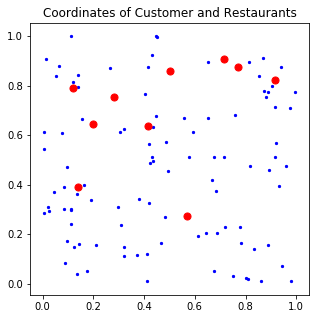

In [1]:
import numpy as np
import matplotlib.pyplot as plt

num_customer = 100
num_restaurants = 10
t_initial_period = 100
t_final = 365
p_going_restaurant = 0.7
unhappiness_bomb_diameter = 0.2
num_unhappy_days = 20

# Create coordinates of customer and restaurants
coord_customer = np.random.rand(num_customer,2)
coord_restaurants = np.random.rand(num_restaurants,2)
plt.figure(figsize=(5,5))
plt.scatter(coord_customer[:,0],coord_customer[:,1],s=5,c='b')
plt.scatter(coord_restaurants[:,0],coord_restaurants[:,1],s=50,c='r')
plt.title("Coordinates of Customer and Restaurants")
plt.show()

In [2]:
# Distance and probability calcualtion for each customer
import scipy as sp
from scipy.spatial.distance import cdist
dist_customer_restaurants = cdist(coord_restaurants,coord_customer) # Pairwise Euclidean distance
dist_normalization = dist_customer_restaurants.sum(axis=0) #Normalize the distances

# Create separate probabilities for weekdays and weekends and add staying at home as a final probability
p_customer_restaurant = np.divide(dist_customer_restaurants,dist_normalization)
p_customer_restaurant_weekdays = p_customer_restaurant*p_going_restaurant
p_customer_restaurant_weekdays = np.concatenate((p_customer_restaurant_weekdays,np.full((1,num_customer),1-p_going_restaurant)))
p_customer_restaurant_weekends = p_customer_restaurant*p_going_restaurant/2
p_customer_restaurant_weekends = np.concatenate((p_customer_restaurant_weekends,np.full((1,num_customer),1-p_going_restaurant/2)))

In [3]:
idx_restaurans = np.arange(num_restaurants+1)
# visit_customer holds everyday visits for every customers. Rows are customers, columns are days
visit_customer = np.zeros((num_customer,t_final))

# Create weekdays and weekends
i_days = np.arange(t_final)
days_weekdays = np.logical_and(i_days%7<5,i_days<t_initial_period)
days_weekends = np.logical_and(i_days%7>=5,i_days<t_initial_period)

# Assign visits by sampling with replacement over visiting probabilities for every person
# Since visits are independent, all visits can be sampled simultaneously, given that probability distribution doesn't change
for i in range(num_customer):
    visit_customer[i,days_weekdays] = np.random.choice(idx_restaurans,np.sum(days_weekdays),p=p_customer_restaurant_weekdays[:,i])
    visit_customer[i,days_weekends] = np.random.choice(idx_restaurans,np.sum(days_weekends),p=p_customer_restaurant_weekends[:,i])

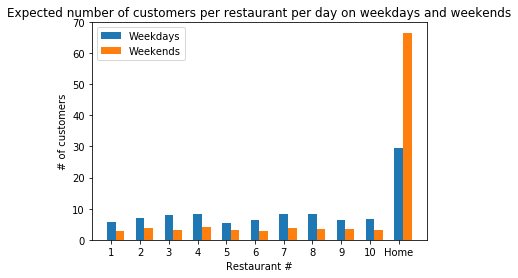

In [4]:
# Create Histogram for Weekdays and Weekends visit to see the probability change
H_weekdays, _ = np.histogram(visit_customer[:,days_weekdays],bins=num_restaurants+1)
H_weekends, _ = np.histogram(visit_customer[:,days_weekends],bins=num_restaurants+1)

# Normalize visit numbers by number of days to calculate a comparable metric
plt.bar(idx_restaurans,H_weekdays/np.sum(days_weekdays),0.3)
plt.bar(idx_restaurans+0.3,H_weekends/np.sum(days_weekends),0.3)
plt.title('Expected number of customers per restaurant per day on weekdays and weekends')
plt.xlabel('Restaurant #')
plt.ylabel('# of customers')
plt.legend(['Weekdays','Weekends'])
plt.xticks(idx_restaurans,[str(x) for x in range(1,num_restaurants+1)]+['Home'])
plt.show()

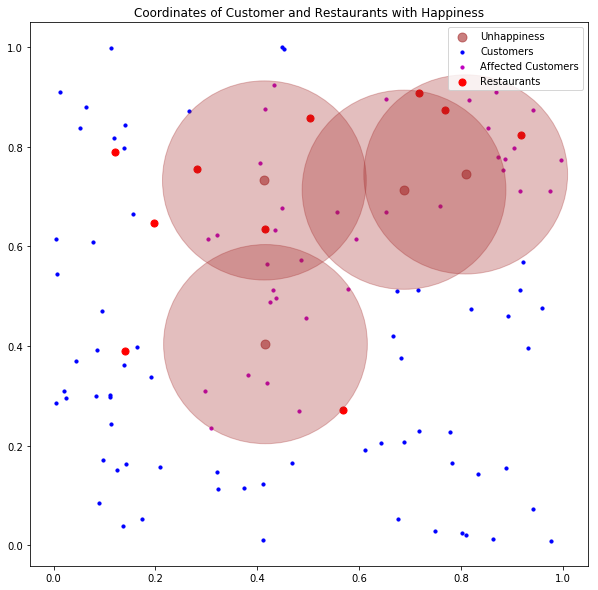

In [6]:
# Unhappiness bomb and affected people
happiness_index = np.ones((num_customer,t_final))
coord_unhappiness_bomb = np.random.rand(4,2)
unhappy_distance = cdist(coord_customer,coord_unhappiness_bomb)
unhappy_people_idx = np.min(unhappy_distance,axis=1)<unhappiness_bomb_diameter
unhappy_days = set(np.random.choice(range(t_initial_period,t_final),num_unhappy_days,replace=False))

fig = plt.figure(figsize=(10,10))
ax= fig.gca()
for x,y in coord_unhappiness_bomb:
    q = plt.Circle((x,y),radius = 0.2,color='brown',alpha = 0.3)
    ax.add_artist(q)
plt.scatter(coord_unhappiness_bomb[:,0],coord_unhappiness_bomb[:,1],s=80,c='brown',alpha=0.6)
plt.scatter(coord_customer[~unhappy_people_idx,0],coord_customer[~unhappy_people_idx,1],s=10,c='b')
plt.scatter(coord_customer[unhappy_people_idx,0],coord_customer[unhappy_people_idx,1],s=10,c='m')
plt.scatter(coord_restaurants[:,0],coord_restaurants[:,1],s=50,c='r')
plt.legend(['Unhappiness','Customers','Affected Customers','Restaurants'])
plt.title("Coordinates of Customer and Restaurants with Happiness")
plt.show()

In [10]:
# Customer visit generation after unhappiness addition
# Because from now on probability distribution depends on the previous day, we can either:
    # simulate each day with associated probability
    # simulate days between unhappiness events
# I choose the first one for better readability and maintainability
for i in range(num_customer):
    for day in range(t_initial_period,t_final):
        happiness_index[i,day] = happiness_index[i,day-1]
        if unhappy_people_idx[i] == True and day in unhappy_days:
            if np.random.rand() < 0.5:
                happiness_index[i,day] =0.9*happiness_index[i,day-1]
        prob_go_out = happiness_index[i,day]*p_going_restaurant
        if day % 7 >=5:
            prob_go_out /= 2
        if np.random.rand() > prob_go_out: #stay at home
            visit_customer[i,day] = num_restaurants
        else:
            visit_customer[i,day] = np.random.choice(np.arange(num_restaurants),p=p_customer_restaurant[:,i])

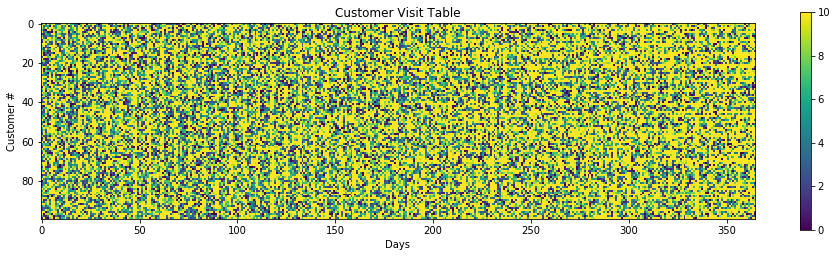

In [11]:
# Showing the final dataset raw data
# Unhappiness events can be seen by horizontal lines extruding after certain points
plt.figure(figsize=(16,4))
plt.imshow(visit_customer)
plt.colorbar()
plt.title('Customer Visit Table')
plt.xlabel('Days')
plt.ylabel('Customer #')
plt.show()

In [15]:
# Table Generation
import pandas as pd
df_happiness = pd.DataFrame(happiness_index)
df_visit_customer = pd.DataFrame(visit_customer)